In [119]:
import sys
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor

import fraud_detection as fd
from fraud_detection import data_loader, metrics
from fraud_detection.models.costoptim import bewertung

# Add the src directory to the system path to import modules
reload(fd)
sys.path.append('../src')

datapath = "../data/transformed_label_and_damage.parquet"

In [86]:
seed = 42

In [87]:
def get_balanced_data(X_train, y_train, seed=42):
    n_damage = np.sum(y_train[:, 1] > 0)
    n_no_damage = np.sum(y_train[:, 1] == 0)
    n_samples = min(n_damage, n_no_damage)
    idx_balanced = np.concatenate([
            np.random.choice(np.where(y_train[:, 1] > 0)[0], n_samples, replace=False),
            np.random.choice(np.where(y_train[:, 1] == 0)[0], n_samples, replace=False),
    ])
    X_train = X_train[idx_balanced]
    y_train = y_train[idx_balanced]
    return X_train, y_train


def get_data_with_damage_only(X_train, y_train):
    idx_damage = np.where(y_train[:, 1] > 0)[0]
    X_damage = X_train[idx_damage,:]
    y_damage = y_train[idx_damage,:]
    return X_damage, y_damage

In [88]:
X, targets = data_loader.load_data_np(datapath)

X_train, X_test, y_train, y_test = train_test_split(
    X, targets, test_size=0.2, random_state=seed, stratify=targets[:, 1] > 0
)

In [89]:
X_train_full, y_train_full = X_train.copy(), y_train.copy()
X_test_full, y_test_full = X_test.copy(), y_test.copy()

In [90]:
X_train_damage_only, y_train_damage_only = get_data_with_damage_only(X_train, y_train)

In [91]:
X_train_balanced, y_train_balanced = get_balanced_data(X_train, y_train, seed=seed)

In [ ]:
label_true = (y_test[:, 0] != 0).astype(int)

In [122]:
clf = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective="binary:logistic",
)

clf.fit(X_train_full, y_train_full[:, 0] > 0)
probs_baseline = clf.predict_proba(X_test_full)[:, 1]
preds_baseline = clf.predict(X_test_full)

metrics_baseline = metrics.bewertung(probs_baseline, preds_baseline, y_test_full[:, 0], y_test_full[:, 1])
metrics_baseline

{'cm': array([[28580,    94],
        [  382,   474]]),
 'precision': 0.8345070422535211,
 'recall': 0.5537383177570093,
 'f1': 0.6657303370786517,
 'mcc': 0.6723856163584601,
 'auc-pr:': 0.7297875373627742,
 'damage_total': np.float64(5961.9400000000005),
 'damage_prevented': np.float64(3719.92),
 'damage_missed': np.float64(2242.02),
 'detected bonus': np.int64(2370),
 'fp penalty': np.int64(940),
 'Bewertung': np.float64(-812.02)}

In [125]:
metrics.print_metrics(metrics_baseline)

cm
[[28580    94]
 [  382   474]]
precision                0.83
recall                   0.55
f1                       0.67
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      3719.92
damage_missed         2242.02
detected bonus        2370.00
fp penalty             940.00
Bewertung             -812.02


In [133]:
def fit_and_predict(X_train, y_train, X_test, y_test):
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        objective="reg:squarederror",
    )

    #sample_weights = np.where(y_train[:, 0] > 0, 200.0, 1.0)
    model.fit(X_train, y_train[:, 1])#, sample_weight=sample_weights)

    #model.fit(X_train, y_train[:, 1])
    preds = model.predict(X_test)
    bew = metrics.regression(preds, y_test[:, 0])

    return model, bew, preds

In [134]:
model_full, bew_full, preds_full = fit_and_predict(X_train_full, y_train_full, X_test_full, y_test_full)
model_damage_only, bew_damage_only, preds_damage_only = fit_and_predict(
    X_train_damage_only, y_train_damage_only, X_test_full, y_test_full
)
model_balanced, bew_balanced, preds_balanced = fit_and_predict(
    X_train_balanced, y_train_balanced, X_test_full, y_test_full
)

In [103]:
bew_full

{'MSE': 0.9987136755999687,
 'RMSE': np.float64(0.999356630838045),
 'MAE': 0.1956352912719893,
 'R2': -34.481816468556325}

In [104]:
bew_damage_only

{'MSE': 40.39763875930796,
 'RMSE': np.float64(6.355913684066828),
 'MAE': 5.834507470182372,
 'R2': -1434.2277727244605}

In [105]:
bew_balanced

{'MSE': 5.9374202104464535,
 'RMSE': np.float64(2.436682213676304),
 'MAE': 1.2882378413602322,
 'R2': -209.9417937800838}

In [ ]:
def find_threshold(threshold, preds, ytrue, damage):
  threshold_grid = np.tile(threshold, (len(ytrue), 1)).T
  preds = (preds > threshold_grid).astype(int)
  res = bewertung(preds, ytrue, damage)
  idx = np.argmax(res)
  return res, threshold[idx], idx

threshold = np.linspace(0.1, 20, 1000)

res_full, threshold_full, idx_full = find_threshold(threshold, preds_full, label_true, y_test[:, 1])
res_damage_only, threshold_damage_only, idx_damage_only = find_threshold(threshold, preds_damage_only, label_true, y_test[:, 1])
res_balanced, threshold_balanced, idx_balanced = find_threshold(threshold, preds_balanced, label_true, y_test[:, 1])


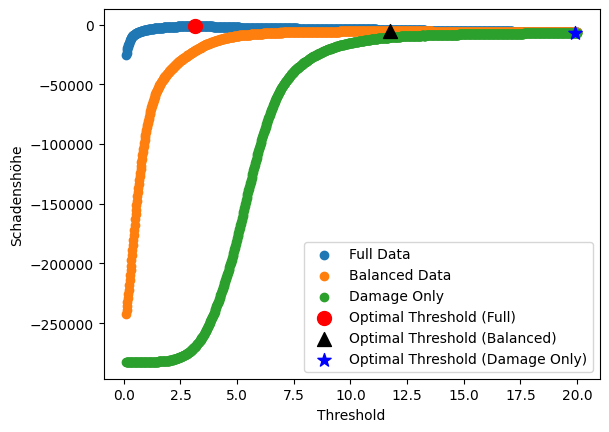

In [118]:
# plot a figure with three subplots

plt.scatter(threshold, res_full, label="Full Data")
plt.scatter(threshold, res_balanced, label="Balanced Data")
plt.scatter(threshold, res_damage_only, label="Damage Only")
plt.xlabel("Threshold")
plt.ylabel("Schadenshöhe")

plt.scatter(x=threshold_full,y=res_full[idx_full], marker='o', color='red', s=100, label='Optimal Threshold (Full)')
plt.scatter(x=threshold_balanced,y=res_balanced[idx_balanced], marker='^', color='black', s=100, label='Optimal Threshold (Balanced)')
plt.scatter(x=threshold_damage_only,y=res_damage_only[idx_damage_only], marker='*', color='blue', s=100, label='Optimal Threshold (Damage Only)')
plt.legend()

plt.show()


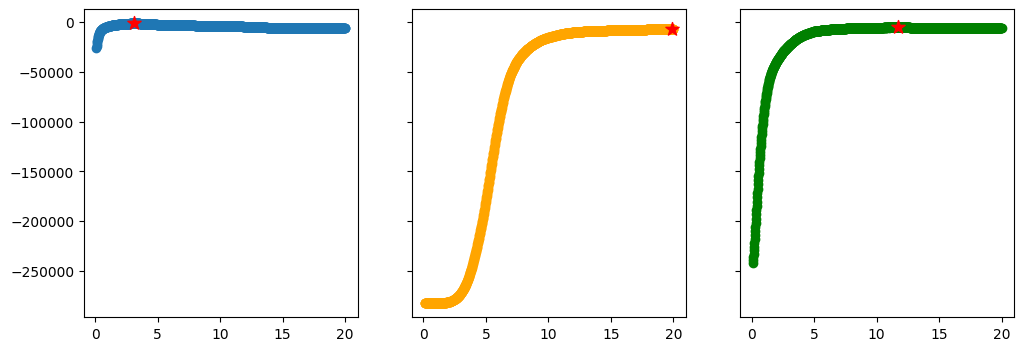

In [109]:
# plot a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axs[0].scatter(threshold, res_full, label="Full Data")
axs[0].scatter(x=threshold_full,y=res_full[idx_full], marker='*', color='red', s=100, label='Red Triangle')

axs[1].scatter(threshold, res_damage_only, label="Damage Only", color="orange")
axs[1].scatter(x=threshold_damage_only,y=res_damage_only[idx_damage_only], marker='*', color='red', s=100, label='Red Triangle')

axs[2].scatter(threshold, res_balanced, label="Balanced Data", color="green")
axs[2].scatter(x=threshold_balanced,y=res_balanced[idx_balanced], marker='*', color='red', s=100, label='Red Triangle')

plt.show()


In [ ]:
yhat_full = (preds_full > threshold_full).astype(int)
label_true = (y_test[:, 0] != 0).astype(int)
metrics_full = metrics.bewertung(yhat_full, yhat_full, label_true, y_test[:, 1])
metrics.print_metrics(metrics_full)

cm
[[28574   100]
 [  440   416]]
precision                0.81
recall                   0.49
f1                       0.61
mcc                      0.62
auc-pr:                  0.41
damage_total          5961.94
damage_prevented      3767.06
damage_missed         2194.88
detected bonus        2080.00
fp penalty            1000.00
Bewertung            -1114.88


In [ ]:
yhat_balanced = (preds_balanced > threshold_balanced).astype(int)
label_true = (y_test[:, 0] != 0).astype(int)
metrics.bewertung(yhat_balanced, yhat_balanced, label_true, y_test[:, 1])

{'cm': array([[28532,   142],
        [  739,   117]]),
 'precision': 0.4517374517374517,
 'recall': 0.1366822429906542,
 'f1': 0.20986547085201793,
 'mcc': 0.2370266199832045,
 'auc-pr:': 0.08676988604679753,
 'damage_total': np.float64(5961.9400000000005),
 'damage_prevented': np.float64(1681.68),
 'damage_missed': np.float64(4280.26),
 'detected bonus': np.int64(585),
 'fp penalty': np.int64(1420),
 'Bewertung': np.float64(-5115.26)}

In [ ]:
yhat_damage_only = (preds_damage_only > threshold_damage_only).astype(int)
label_true = (y_test[:, 0] != 0).astype(int)
metrics.bewertung(yhat_damage_only, yhat_damage_only, label_true, y_test[:, 1])

{'cm': array([[28563,   111],
        [  846,    10]]),
 'precision': 0.08264462809917356,
 'recall': 0.011682242990654205,
 'f1': 0.02047082906857728,
 'mcc': 0.020514580691354218,
 'auc-pr:': 0.02961430632390654,
 'damage_total': np.float64(5961.9400000000005),
 'damage_prevented': np.float64(171.3),
 'damage_missed': np.float64(5790.639999999999),
 'detected bonus': np.int64(50),
 'fp penalty': np.int64(1110),
 'Bewertung': np.float64(-6850.639999999999)}

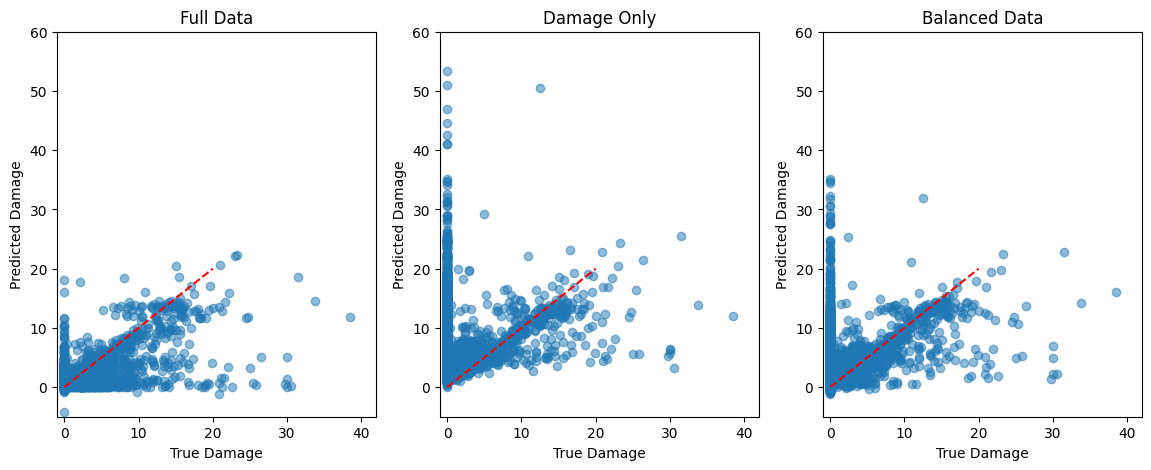

In [ ]:
# scatter plot of high damage predictions vs true values ordered by true values
# scales axis with 1:1 line
# three plots next to each other
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].scatter(y_test[:, 1], preds_full, alpha=0.5)
axs[0].set_xlabel("True Damage")
axs[0].set_ylabel("Predicted Damage")
axs[0].set_title("Full Data")
axs[0].plot([0, 20], [0, 20], color='r', linestyle='--')
axs[0].set_xlim(-1, 42)
axs[0].set_ylim(-5, 60)

axs[1].scatter(y_test[:, 1], preds_damage_only, alpha=0.5)
axs[1].set_xlabel("True Damage")
axs[1].set_ylabel("Predicted Damage")
axs[1].set_title("Damage Only")
axs[1].plot([0, 20], [0, 20], color='r', linestyle='--')
axs[1].set_xlim(-1, 42)
axs[1].set_ylim(-5, 60)

axs[2].scatter(y_test[:, 1], preds_balanced, alpha=0.5)
axs[2].set_xlabel("True Damage")
axs[2].set_ylabel("Predicted Damage")
axs[2].set_title("Balanced Data")
axs[2].plot([0, 20], [0, 20], color='r', linestyle='--')
axs[2].set_xlim(-1, 42)
axs[2].set_ylim(-5, 60)

plt.show()

# Kombiniertes Modell

In [163]:
from scipy.optimize import minimize_scalar

In [ ]:
# Baseline
metrics.print_metrics(metrics_baseline)

cm
[[28580    94]
 [  382   474]]
precision                0.83
recall                   0.55
f1                       0.67
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      3719.92
damage_missed         2242.02
detected bonus        2370.00
fp penalty             940.00
Bewertung             -812.02


In [206]:
def cost_fn(probs, damage, malus, bonus=5):
    return probs > malus / (bonus + malus + damage)

def bewertung(yhat, y, damage):
    res = np.zeros(yhat.shape)
    #y = y[None, :]
    #damage = damage[None, :]


    # Case 1: FRAUD caught
    res += ((y == 1) & (yhat == 1)) * 5
    # Case 2: False positive
    res -= ((y == 0) & (yhat == 1)) * 10
    # Case 3: FRAUD missed
    res -= ((y == 1) & (yhat == 0)) * damage
    return res.sum()


In [207]:
def value_fn(probs, damage_preds, theta1, theta2, label_true, damage_true):
    #print(label_true.shape, damage_true.shape, probs.shape, damage_preds.shape, theta.shape)
    yhat = cost_fn(probs, damage_preds, theta1, theta2)
    return bewertung(yhat, label_true, damage_true)

# Full

In [201]:
probs_train = clf.predict_proba(X_train_full)[:, 1]
damage_preds_train_full= model_full.predict(X_train_full)

p_preds = probs_train
d_preds = damage_preds_train_full

def objective(theta):
    values = value_fn(p_preds, d_preds, theta, y_train[:, 0], y_train[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 5.0), method='bounded')
best_theta = res.x

probs_test = clf.predict_proba(X_test_full)[:, 1]
damage_preds_test = model_full.predict(X_test_full)
th = best_theta
yhat_test_full = cost_fn(probs_test, damage_preds_test, th)
th

np.float64(3.91849823449767)

In [203]:
p_preds = probs_test
d_preds = damage_preds_test

def objective(theta):
    values = value_fn(p_preds, d_preds, theta, y_test[:, 0], y_test[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 5.0), method='bounded')
best_theta = res.x

probs_test = clf.predict_proba(X_test_full)[:, 1]
damage_preds_test = model_full.predict(X_test_full)
th = best_theta
yhat_test_full = cost_fn(probs_test, damage_preds_test, th)
th

np.float64(4.489505950426634)

In [178]:
m = metrics.bewertung(probs_test, yhat_test_full, y_test[:, 0], y_test[:, 1])
metrics.print_metrics(m)

cm
[[28505   169]
 [  338   518]]
precision                0.75
recall                   0.61
f1                       0.67
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      4027.66
damage_missed         1934.28
detected bonus        2590.00
fp penalty            1690.00
Bewertung            -1034.28


# Balanced Data

In [184]:
damage_preds_train_balanced = model_balanced.predict(X_train_full)

p_preds = probs_train
d_preds_balanced = damage_preds_train_balanced

def objective(theta):
    values = value_fn(p_preds, d_preds_balanced, theta, y_train[:, 0], y_train[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 20.0), method='bounded')
theta_balanced = res.x
print(theta_balanced)

damage_preds_test_balanced = model_balanced.predict(X_test_full)
yhat_test_balanced = cost_fn(probs_test, damage_preds_test_balanced, theta_balanced)

7.7145808817972705


In [ ]:
p_preds = probs_test
d_preds_balanced = damage_preds_test_balanced

def objective(theta):
    values = value_fn(p_preds, d_preds_balanced, theta, y_test[:, 0], y_test[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 20.0), method='bounded')
theta_balanced = res.x
print(theta_balanced)

yhat_test_balanced = cost_fn(probs_test, damage_preds_test_balanced, theta_balanced)

12.552811121912281


In [212]:
from scipy.optimize import minimize

p_preds = probs_test
d_preds_balanced = damage_preds_test_balanced

def objective(theta_vec):
    theta1, theta2 = theta_vec
    values = value_fn(p_preds, d_preds_balanced, theta1, theta2, y_test[:, 0], y_test[:, 1])
    return -np.mean(values)  # negative because we minimize


initial_guess = [1.0, 2.0]

result = minimize(
    objective,
    x0=initial_guess,
    bounds=[(0.1, 40.0), (0.1, 40.0)],  # bounds for theta1 and theta2
    method='L-BFGS-B'  # good for bounded continuous optimization
)

theta_balanced = result.x
print(theta_balanced)

yhat_test_balanced = cost_fn(probs_test, damage_preds_test_balanced, *theta_balanced)

[1. 2.]


In [198]:
m = metrics.bewertung(probs_test, yhat_test_balanced, y_test[:, 0], y_test[:, 1])
metrics.print_metrics(m)

cm
[[28598    76]
 [  393   463]]
precision                0.86
recall                   0.54
f1                       0.66
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      3690.57
damage_missed         2271.37
detected bonus        2315.00
fp penalty             760.00
Bewertung             -716.37


# Damage only model

In [193]:
damage_preds_train_damage_only = model_damage_only.predict(X_train_full)

p_preds = probs_train
d_preds_damage_only = damage_preds_train_damage_only

def objective(theta):
    values = value_fn(p_preds, d_preds_damage_only, theta, y_train[:, 0], y_train[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 20.0), method='bounded')
theta_damage_only = res.x
print(theta_damage_only)

damage_preds_test_damage_only = model_damage_only.predict(X_test_full)
yhat_test_damage_only = cost_fn(probs_test, damage_preds_test_damage_only, theta_damage_only)

6.583900692417035


In [199]:
p_preds = probs_test
d_preds_damage_only = damage_preds_test_damage_only

def objective(theta):
    values = value_fn(p_preds, d_preds_damage_only, theta, y_test[:, 0], y_test[:, 1])
    return -np.mean(values)  # negative because we minimize


res = minimize_scalar(objective, bounds=(0.1, 20.0), method='bounded')
theta_damage_only = res.x
print(theta_damage_only)

damage_preds_test_damage_only = model_damage_only.predict(X_test_full)
yhat_test_damage_only = cost_fn(probs_test, damage_preds_test_damage_only, theta_damage_only)

12.398879980952653


In [200]:
m = metrics.bewertung(probs_test, yhat_test_balanced, y_test[:, 0], y_test[:, 1])
metrics.print_metrics(m)

cm
[[28598    76]
 [  393   463]]
precision                0.86
recall                   0.54
f1                       0.66
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      3690.57
damage_missed         2271.37
detected bonus        2315.00
fp penalty             760.00
Bewertung             -716.37


In [ ]:
# Baseline
metrics.print_metrics(metrics_baseline)

cm
[[28580    94]
 [  382   474]]
precision                0.83
recall                   0.55
f1                       0.67
mcc                      0.67
auc-pr:                  0.73
damage_total          5961.94
damage_prevented      3719.92
damage_missed         2242.02
detected bonus        2370.00
fp penalty             940.00
Bewertung             -812.02
